# PSTAT 176/276 Project #

# Initialization

In [1]:
# !pip install progressbar
# !pip install --upgrade pandas

In [2]:
from progressbar import ProgressBar

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
#from sklearn.neighbors import kneighbors_graph, NearestNeighbors
import scipy
import scipy.sparse as sparse
from scipy.stats import norm
import matplotlib.pyplot as plt

# Problem 1

Make a function StockVol to calibrate the stock volatility under geometric Brownian motion model. Input histoPrice is an array of 1-year historical prices. You can choose a
stock that does not pay dividends for simplicity. The function should return a number that is the
historical volatility of the stock.

In [4]:
def StockVol(histoPrice):
    """
    Compute the stock volatility under GBM using 1-year historical prices
    
    Inputs:
        histoPrice: an array of daily historical prices for one year
        
    Returns:
        histoVol: annualized historical volatility
    """
    
    logret = np.diff(np.log(histoPrice))
    sigma = np.sqrt(np.var(logret))
    histoVol = sigma*np.sqrt(252)  # annualize volatility
    
    return histoVol

# Problem 2
Make a function StockPath to generate n stock paths where n is one of the inputs,
as well as sigma which is the volatility of the stock. Other inputs needed (might not be limited to)
are S0: current stock price; T: terminal time in yearly unit; np: number of time periods; r: interest
rate; delta: continuous dividend yield of the stock.

In [5]:
def StockPath(n,sigma=0.2,S0=100,T=1,nump=252,r=0.01,delta = 0):
    """
    Generate n stock paths
    
    Inputs:
        n: number of paths generated
        sigma: volatility of the stock
        S0: current stock price
        T: terminal time in yearly unit
        nump: number of time periods
        r: interest rate
        delta: continuous dividend yield of the stock
        
    Returns:
        S: an array of stock paths
    """
    
    X = np.zeros((n,1+nump))
    X[:,0] = S0
    for i in range(len(X)):
        Z = np.random.normal(0, 1, nump)
        X[i,1:]=np.exp(sigma*np.sqrt(T/nump)*Z+(r-delta-sigma**2/2)*(T/nump))
    
    S = []   
    for i in range (n):
        S.append(np.cumprod(X[i,:]))
    
    return np.array(S)

# Problem 3
Make a function EurOptPrice that takes the stock paths to generate the European
put option price through Monte Carlo method. One input is n stock paths. The function should
return the discounted payoff vector, price, and variance.


In [6]:
def EurOptPrice(paths,K,r=0.01,T=1):
    """
    generate the European put option price through Monte Carlo method
    
    Inputs:
        paths: an array of stock paths
        K: strike price
        r: interest rate
        T: terminal time
        
    Returns:
        Payoff: discounted payoffs
        price: estimated price of the European put option
        variance: variance of discounted payoffs
        
    """
    
    Payoff = np.maximum(K-paths[:,-1],0)*np.exp(-r*T)
    price = np.mean(Payoff)
    variance = np.var(Payoff)
    
    return (Payoff,price,variance)
    

# Problem 4
Make a function AmeOptPrice that takes the stock paths to generate the American put option price without control variates. The function should return the discounted payoff
vector, price, and variance. In this part, you will need to implement some regression method and
you are required to do it by using machine learning or deep learning. Make sure to explain what
you did in the analysis file.

In [7]:
def AmeOptPrice(paths,K,r=0.01,T=1,nump = 252,delta = 0,sigma=0.2):
    """
    generate the American put option price without control variable
    
    Inputs:
        paths: an array of stock paths
        K: strike price
        r: interest rate
        T: terminal time
        nump: number of periods
        
    Returns:
        Payoff: discounted payoffs
        price: estimated price of the American put option
        variance: variance of discounted payoffs
        
    """
    deltaT = T/nump
    P = np.maximum(K-paths,0)  # payoffs if early exercise
    H = np.zeros(paths.shape)  # holding value
    V = np.zeros(paths.shape)  # value of the option
    
    H[:,-1] = P[:,-1]
    V[:,-1] = P[:,-1]
    
    # compute the expected payoff at termial time given S_(T-1) using one step monte carlo
    tmp = paths[:,-2]
    for i in range(len(paths)):
        tmp_Price = StockPath(100,sigma,tmp[i],deltaT,1,r,delta)
        tmp_payoff = np.maximum(K-tmp_Price[:,-1],0)*np.exp(-r*deltaT)
        H[i,-2] = np.mean(tmp_payoff)
    V[:,-2] = np.maximum(P[:,-2], H[:,-2])  # value of the option at t = T-1
    
    rf = RandomForestRegressor(n_estimators=30, n_jobs=-1)  #Define Random Forest Regressor 
    
    pbar = ProgressBar()
    for i in pbar(range(2,len(V[0]))):
        X = paths[:,-i].reshape(-1,1)
        Y = V[:,-i].reshape(-1,1)
        
        reg = rf.fit(X, Y.ravel())  # Polynomial regression (degree = 5)
        
        tmp = paths[:,-i-1]
        for j in range(len(paths)):
            tmp_Price = StockPath(100,sigma,tmp[j],deltaT,1,r,delta)
            tmp_V = rf.predict(tmp_Price.reshape(-1,1))*np.exp(-r*deltaT)
            H[j,-i-1] = np.mean(tmp_V)
        V[:,-i-1] = np.maximum(P[:,-i-1], H[:,-i-1])
 
    #Determine the optimal stopping time and payoffs
    Payoff = [0]*len(P)
    for i in range(len(P)):
        idx = np.where(P[i,:]> H[i,:])[0]
        if(len(idx) == 0):
            Payoff[i] = V[i,-1]*np.exp(-r*T)
        else:
            Payoff[i] = V[i,idx[0]]*np.exp(-r*idx[0]*deltaT)

    price = np.mean(Payoff)
    variance = np.var(Payoff)
    
    return(Payoff, price, variance)    

We chose to use Random Forest to build the AmePut function because Random Forest is a powerful algorithm in Machine Learning, can be used to solve regression problems, and works well with continuous variables. Also, compared to decision trees, Random Forest reduces the variance and hence improves the accuracy. 

# Problem 5
Make a function ContVariate to implement the control variates method. Note that
this part is independent of the prices you computed. You should be able to apply this function to
any vectors and estimations.

In [8]:
def ContVariate(y,x,mu_x):
    """
    Implement the control variates method
    
    Inputs:
        y: an array of samples with unknown mean
        x: an array of samples with known or estimated mean
        mu_x: mean of random variable X
        
    Returns:
        y_hat: estimated mean of y
        y_hatVar: variance of the estimator
        
    """
    
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    y_var = np.var(y)
    corr = np.corrcoef(x,y)[0,1]
    
    beta = beta = np.cov(x,y)[0,1]/np.var(x)
    y_hat = y_bar+beta*(mu_x-x_bar)
#     y_hatVar = (np.var(y)/len(y))*(1-corr**2)
    y_hatVar = np.var(y)*(1-corr**2)
    
    return(y_hat[0],y_hatVar)

In [9]:
def BSput(S0, K, T, r, sigma,q):
    """
    Compute true price of the European put using BS formula
    
    Inputs:
        S0: current stock price
        K: strike price
        T: termial time
        r: interest rate
        sigma: volatility
        q: continuous dividend
        
    Output:
        price: price of the option
    """
    
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    price = (K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S0 * norm.cdf(-d1, 0.0, 1.0))
    
    return price

# Problem 6
Choose your favorite underlying stock and a corresponding put option that expires in
1 year. Use 1 year libor yield as the interest rate. You also need to compute the continuous dividend
yield. Apply the ContVariate function to the American put option price you computed. Do the
analysis as if you want to convince your manager that this is the right way to estimate the price of
American style option.

## McDonald's Stock Analysis

For this part, we decided to use two stocks to test our AmeOptPrice function. The first stock we chose is McDonald's Corporation (MCD). There are 252 trading days in total between June 5, 2019 and June 3, 2020. During this period, MCD paid dividends on Aug 30 2019, Nov 29 2019, Feb 28 2020, and May 29 2020. The dividends are 1.16, 1.25, 1.25, and 1.25 respectively. The stock prices are 217.97, 194.48, 194.17, and 186.32 respectively.

In [10]:
import pandas as pd
MCD = pd.read_excel('data/MCD.xlsx')

In [11]:
#extract the LIBOR rate on June 3, 2020 and historical closing prices from the excel 
LIBOR = np.array(pd.DataFrame(MCD, columns=['LIBOR']))
closingPrice = np.array(pd.DataFrame(MCD, columns=['Close']))
histoPrice = np.zeros((1,252))
for i in range(0,252):
    histoPrice[0,i] = closingPrice[i][0]
    
#calculate the interest rate and continuous dividend yield
r = LIBOR[-1]/100
delta = np.log((1+(1.16/217.97))*(1+(1.25/194.48))*(1+(1.25/194.17))*(1+(1.25/186.32)))
sigma = StockVol(histoPrice)

# Simulate Path
paths = StockPath(100,sigma,histoPrice[0][-1],1,52,r[0],delta)

In [12]:
# American Put Option:
AmePut = AmeOptPrice(paths,200,r[0],1,52,delta,sigma)
print("American Put Option price:", AmePut[1],
     ';\n\t Variance:',AmePut[2])

American Put Option price: 41.014091681925485 ;
	 Variance: 1210.303850660121


In [13]:
#compute the true price of the American put by using the Black-Scholes model 
truePrice = BSput(histoPrice[0][-1], 200, 1, r, sigma, delta)
print("True Put Price:",truePrice[0])

#compute the price of the European put on MCD
EurPut = EurOptPrice(paths, 200, r, 1)
print("European Put Option price:", EurPut[1],
     ';\n\t Variance:',EurPut[2])

#apply the ContVariate function
y_hat,y_hatVar = ContVariate(AmePut[0], EurPut[0], truePrice)
print("Cont-Variate Price:",y_hat,
     "\n\t Variance:",y_hatVar)

True Put Price: 33.60733581303151
European Put Option price: 41.79500931056354 ;
	 Variance: 1495.9324818760165
Cont-Variate Price: 34.14561128798918 
	 Variance: 178.53437437037013


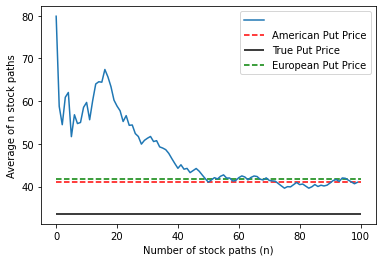

In [41]:
Ame_cum=np.cumsum(AmePut[0])
price=[]
for i in range(len(Ame_cum)):
    price.append(Ame_cum[i]/(i+1))

plt.plot(price)
plt.hlines(AmePut[1],0,100,'r','dashed')
plt.hlines(truePrice[0],0,100)
plt.hlines(EurPut[1],0,100,'g','dashed')
plt.legend(['','American Put Price','True Put Price','European Put Price'])
plt.xlabel("Number of stock paths (n)")
plt.ylabel("Average of n stock paths")
plt.show()

### Variance Comparison

In [15]:
AP_mean=[]
AP_var=[]
CV_mean=[]
CV_var=[]

for i in range(20):
    paths = StockPath(100,sigma,histoPrice[0][-1],1,12,r[0],delta)
    AP_temp=AmeOptPrice(paths,200,r[0],1,12,delta,sigma)
    EP_temp=EurOptPrice(paths, 200, r, 1)
    CV_temp=ContVariate(AP_temp[0], EP_temp[0], truePrice)
    AP_mean.append(AP_temp[1])
    AP_var.append(AP_temp[2])
    CV_mean.append(CV_temp[0])
    CV_var.append(CV_temp[1])

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |##################################

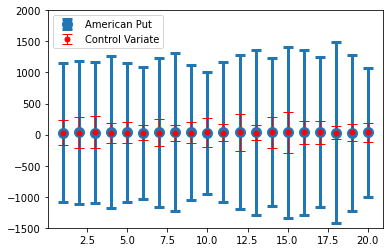

In [23]:
plt.errorbar(range(1,21),AP_mean,AP_var,fmt='.',elinewidth=3, ms=20, capsize=5, capthick=3)
plt.errorbar(range(1,21),CV_mean,CV_var,fmt='.r', elinewidth=1, ms=10, ecolor='red', capsize=5)
plt.legend(('American Put','Control Variate'))
plt.ylim(-1500,2000)
plt.show()

## Apple Stock Analysis

The second stock we chose is Apple Inc. (AAPL). There are 252 trading days in total between June 6, 2019 and June 4, 2020. During this period, AAPL paid dividends on Aug 9 2019, Nov 7 2019, Feb 7 2020, and May 8 2020. The dividends are 0.77, 0.77, 0.77, and 0.82 respectively. The stock prices are 200.99, 259.43, 320.03, and 310.13 respectively.

In [17]:
AAPL = pd.read_excel('data/AAPL.xlsx')

In [18]:
LIBOR = np.array(pd.DataFrame(AAPL, columns=['LIBOR']))
closingPrice = np.array(pd.DataFrame(AAPL, columns=['Close']))
histoPrice = np.zeros((1,252))
for i in range(0,252):
    histoPrice[0,i] = closingPrice[i][0]
r = LIBOR[-1]/100
delta = np.log((1+(0.77/200.99))*(1+(0.77/259.43))*(1+(0.77/320.03))*(1+(0.82/310.13)))
sigma = StockVol(histoPrice)

# Simulate American Put Option:
paths = StockPath(100,sigma,histoPrice[0][-1],1,52,r[0],delta)

In [19]:
# Simulate American Put Option:
AmePut = AmeOptPrice(paths,400,r[0],1,52,delta,sigma)
print("American Put Option price:", AmePut[1],
     ';\n\t Variance:',AmePut[2])

American Put Option price: 96.68537417070301 ;
	 Variance: 5124.28989486787


In [20]:
#apply the Black-Scholes model 
truePrice = BSput(histoPrice[0][-1], 400, 1, r, sigma, delta)
print("True Put Price:",truePrice[0])

#compute the price of the European put on MCD
EurPut = EurOptPrice(paths, 400, r, 1)
print("European Put Option price:", EurPut[1],
     ';\n\t Variance:',EurPut[2])

#apply the ContVariate function
y_hat,y_hatVar = ContVariate(AmePut[0], EurPut[0], truePrice)
print("Cont-Variate Price:",y_hat,
     "\n\t Variance:",y_hatVar)

True Put Price: 102.03153801806573
European Put Option price: 97.80413921909138 ;
	 Variance: 7610.417202535884
Cont-Variate Price: 99.78354979675086 
	 Variance: 1117.9805400837993


The American put option we chose for MCD is MCD210618P00200000 with strike price 200. Its last price, bid price, and ask price are 34.70, 38.75, and 41.45 respectively. The American put option we chose for AAPL is AAPL210618P00400000 with strike price 400. Its last price is 84.85. Bid and ask prices are not available. (All information is from Yahoo Finance.) From the results above, we can see that the price of the American put option calculated by function AmePut is very close to the market last price in both cases. In addition, the price of the American put is greater than the price of the European put which satisfies the general relationship between American and European put options. The option price estimated by the ContVariate function is also very similar to the price calculated by the AmePut function for both stocks, which further proved that function AmePut is the right way to estimated the price of American style options. 